In [1]:
require(ggplot2)
require(data.table)
require(Hmisc)
require(ggthemes)
require(gridExtra)
require(grid)
require(lattice)
require(scales)
require(RColorBrewer)
require(reshape)

Loading required package: ggplot2
Loading required package: data.table
Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: ggthemes
Loading required package: gridExtra

Attaching package: ‘gridExtra’

The following object is masked from ‘package:Hmisc’:

    combine

Loading required package: grid
Loading required package: scales
Loading required package: RColorBrewer
Loading required package: reshape

Attaching package: ‘reshape’

The following object is masked from ‘package:data.table’:

    melt



In [2]:
# install.packages('bit64')

In [3]:
directory = "/mnt/sdb1/baseerat/numerical-evals/12-11-2017/logs-1M"
blues = brewer.pal(n = 6, "Blues")[4:6]
plotTheme <- theme_hc() + theme(legend.title=element_blank(), 
                                legend.position="top", 
                                legend.text=element_text(size=8))

In [4]:
groupSizePerGroupPerTenant <- fread(paste(directory, "group_size_per_group_per_tenant.csv", sep="/"), sep=",", 
                                    header=TRUE)

In [5]:
plt <- ggplot(groupSizePerGroupPerTenant) +
   stat_ecdf(aes(x=groupSize, color="something"), size=1.1) +
   facet_grid(. ~ groupSizeDist) +
   ggtitle("") +
   xlab("Group Size Distributions") +
   ylab("ECDF") +
   scale_color_manual(values=blues) +
   plotTheme + theme(axis.text.x = element_text(angle = 45, hjust = 1),                                 
                     legend.position="none")
ggsave(plt, file="group_size_per_group_per_tenant.pdf", height=2, width=4)

In [6]:
replaceFactors <- function(dt) {
    dt <- dt[placementNumHostsPerLeaf %in% c('uniform', '12')]
    dt[placementNumHostsPerLeaf == '12']$placementNumHostsPerLeaf <- "Placement: Colocated"
    dt[placementNumHostsPerLeaf == 'uniform']$placementNumHostsPerLeaf <- "Placement: Random"
    dt[groupSizeDist == "wve"]$groupSizeDist <- "Group sizes: WVE"
    dt[groupSizeDist == "uniform"]$groupSizeDist <- "Group sizes: Uniform"
    if("podsAlgorithm" %in% colnames(dt)) {
       dt <- dt[podsAlgorithm != "exact-match"]
    }
    if ("leafsAlgorithm" %in% colnames(dt)) {
       dt <- dt[leafsAlgorithm != "exact-match"]
    }
    return(dt)
}

rulesLabeller <- function(rules) {
    paste("Rules: ", rules, sep="")
}

format_si <- function(...) {
  # Format a vector of numeric values according
  # to the International System of Units.
  # http://en.wikipedia.org/wiki/SI_prefix
  #
  # Based on code by Ben Tupper
  # https://stat.ethz.ch/pipermail/r-help/2012-January/299804.html
  # Args:
  #   ...: Args passed to format()
  #
  # Returns:
  #   A function to format a vector of strings using
  #   SI prefix notation
  #
  
  function(x) {
    limits <- c(1e-24, 1e-21, 1e-18, 1e-15, 1e-12,
                1e-9,  1e-6,  1e-3,  1e0,   1e3,
                1e6,   1e9,   1e12,  1e15,  1e18,
                1e21,  1e24)
    prefix <- c("y",   "z",   "a",   "f",   "p",
                "n",   "µ",   "m",   " ",   "K",
                "M",   "G",   "T",   "P",   "E",
                "Z",   "Y")
  
    # Vector with array indices according to position in intervals
    i <- findInterval(abs(x), limits)
  
    # Set prefix to " " for very small values < 1e-24
    i <- ifelse(i==0, which(limits == 1e0), i)

    paste(format(round(x/limits[i], 1),
                 trim=TRUE, scientific=FALSE, ...),
          prefix[i], sep="")
  }
}

In [266]:
groupsCoveredWithBitmapsOnlyForPods <- replaceFactors(fread(paste(directory, 
                                                   "groups_covered_with_bitmaps_only_for_pods.csv", sep="/"), sep=",", 
                                             header=TRUE))


In [267]:
head(groupsCoveredWithBitmapsOnlyForPods)

,groupsCovered,groupsCoveredWithoutDefaultBitmap,groupSizeDist,placementDist,placementNumHostsPerLeaf,seed,podsAlgorithm,podsNumBitmaps,podsNumNodesPerBitmap,podsRedundancyPerBitmap,podsNumRules
1,998466,998466,Group sizes: WVE,colocate-colocate-uniform,Placement: Colocated,2,random-fuzzy-match,3,3,12,10000
2,977071,977071,Group sizes: Uniform,colocate-colocate-uniform,Placement: Colocated,0,random-fuzzy-match,1,3,0,10000
3,977071,977071,Group sizes: Uniform,colocate-colocate-uniform,Placement: Colocated,0,random-fuzzy-match,1,3,0,64000
4,978869,978869,Group sizes: Uniform,colocate-colocate-uniform,Placement: Colocated,0,random-fuzzy-match,1,3,12,10000
5,978869,978869,Group sizes: Uniform,colocate-colocate-uniform,Placement: Colocated,0,random-fuzzy-match,1,3,12,64000
6,977473,977473,Group sizes: Uniform,colocate-colocate-uniform,Placement: Colocated,0,random-fuzzy-match,1,3,6,10000


In [268]:
plt <- ggplot(groupsCoveredWithBitmapsOnlyForPods, aes(y=groupsCoveredWithoutDefaultBitmap, x=factor(podsNumBitmaps), 
                fill=interaction(podsRedundancyPerBitmap))) +
   stat_summary(fun.data=mean_sdl, geom="bar",position=position_dodge(width=0.8), width=0.8) +
   stat_summary(fun.data=mean_sdl, geom="errorbar",position=position_dodge(width=0.8), width=0.2) +
   facet_grid(factor(placementNumHostsPerLeaf) ~ 
              groupSizeDist * podsNumRules, labeller = labeller(podsNumRules = rulesLabeller)) +
   xlab("Number of bitmaps") +
   ylab("Groups covered (without default bitmap)") +
   scale_fill_manual(values=blues, name="Redundancy") +
   plotTheme + theme(legend.title=element_text(size=8)) +
   scale_y_continuous(labels=format_si())
ggsave(plt, file="groups_covered_with_bitmaps_only_for_pods.pdf",  height=4.5, width=7)

In [269]:
groupsCoveredWithBitmapsOnlyForLeafs <- replaceFactors(fread(paste(directory, 
                                                   "groups_covered_with_bitmaps_only_for_leafs.csv", sep="/"), sep=",", 
                                             header=TRUE))

In [270]:
bluesNew = brewer.pal(n = 6, "Blues")[2:6]
plt <- ggplot(groupsCoveredWithBitmapsOnlyForLeafs, aes(y=groupsCoveredWithoutDefaultBitmap, x=factor(leafsNumBitmaps), 
                fill=interaction(leafsRedundancyPerBitmap))) +
   stat_summary(fun.data=mean_sdl, geom="bar",position=position_dodge(width=0.8), width=0.8) +
   stat_summary(fun.data=mean_sdl, geom="errorbar",position=position_dodge(width=0.8), width=0.2) +
   facet_grid(factor(placementNumHostsPerLeaf) ~ groupSizeDist * leafsNumRules
             , labeller = labeller(leafsNumRules = rulesLabeller)) +
   xlab("Number of bitmaps") +
   ylab("Groups covered (without default bitmap)") +
   scale_fill_manual(values=bluesNew, name="Redundancy") +
   scale_y_continuous(labels=format_si()) +
   plotTheme + theme(legend.title=element_text(size=8))
ggsave(plt, file="groups_covered_with_bitmaps_only_for_leafs.pdf",  height=4.5, width=7)

In [271]:
ruleCountForPods <- replaceFactors(fread(paste(directory, "rule_count_for_pods.csv", sep="/"), sep=",", header=TRUE))

In [272]:
plt <- ggplot(ruleCountForPods) +
    geom_boxplot(aes(y=numRules, x=factor(podsNumBitmaps), 
                     fill=interaction(podsRedundancyPerBitmap)),
                 outlier.size=0.5) +
    facet_grid(factor(placementNumHostsPerLeaf)~ groupSizeDist * podsNumRules, 
               labeller = labeller(podsNumRules = rulesLabeller)) +
    xlab("Number of bitmaps") +
    ylab("Number of rules") +
    scale_fill_manual(values=bluesNew, name="Redundancy") +
    scale_y_continuous(labels=format_si()) +
    plotTheme + theme(legend.title=element_text(size=8))
ggsave(plt, file="rule_count_for_pods.pdf",  height=4.5, width=7)

In [273]:
ruleCountForLeafs <- replaceFactors(fread(paste(directory, "rule_count_for_leafs.csv", sep="/"), sep=",", header=TRUE))

In [274]:
plt <- ggplot(ruleCountForLeafs) +
    geom_boxplot(aes(y=numRules, x=factor(leafsNumBitmaps), 
                     fill=interaction(leafsRedundancyPerBitmap)),
                 outlier.size=0.5) +
    facet_grid(factor(placementNumHostsPerLeaf) ~ groupSizeDist * leafsNumRules, 
               labeller = labeller(leafsNumRules = rulesLabeller)) +
    xlab("Number of bitmaps") +
    ylab("Number of rules") +
    scale_fill_manual(values=bluesNew, name="Redundancy") +
    scale_y_continuous(labels=format_si()) +
    plotTheme + theme(legend.title=element_text(size=8))
ggsave(plt, file="rule_count_for_leafs.pdf", height=4.5, width=7)

In [25]:
trafficPerGroupPerTenant <- replaceFactors(fread(paste(directory, "traffic_per_group_per_tenant_corrected.csv", sep="/"), sep=",", 
                                  header=TRUE))
trafficPerGroupPerTenant$unicastTraffic <- as.numeric(trafficPerGroupPerTenant$unicastTraffic)
trafficPerGroupPerTenant$multicastTraffic <- as.numeric(trafficPerGroupPerTenant$multicastTraffic)
trafficPerGroupPerTenant$baseeratTraffic <- as.numeric(trafficPerGroupPerTenant$baseeratTraffic)
trafficPerGroupPerTenant$overlayTraffic <- as.numeric(trafficPerGroupPerTenant$overlayTraffic)
trafficPerGroupPerTenant$overlayTrafficCorrected <- as.numeric(trafficPerGroupPerTenant$overlayTrafficCorrected)

In [26]:
trafficMelted <- melt(trafficPerGroupPerTenant, id=c("groupSizeDist", "placementDist", "placementNumHostsPerLeaf", "seed",
                                    "podsAlgorithm", "podsNumBitmaps", "podsNumNodesPerBitmap",
                                    "podsRedundancyPerBitmap", "podsNumRules", "leafsAlgorithm",
                                    "leafsNumBitmaps", "leafsNumNodesPerBitmap", "leafsRedundancyPerBitmap",
                                    "leafsNumRules", "multicastTraffic"))
trafficMelted <- trafficMelted[!(variable == "unicastTraffic" & leafsRedundancyPerBitmap > 0)]
trafficMelted <- trafficMelted[!(variable == "overlayTrafficCorrected" & leafsRedundancyPerBitmap > 0)]
trafficMelted[variable == "baseeratTraffic"]$variable <- "Baseerat"
trafficMelted$redundancyAndAlgo <- interaction(trafficMelted$variable, 
                                               trafficMelted$leafsRedundancyPerBitmap, sep=":R=")
trafficMelted[redundancyAndAlgo == "unicastTraffic:R=0"]$redundancyAndAlgo <- "Unicast"
trafficMelted[redundancyAndAlgo == "overlayTrafficCorrected:R=0"]$redundancyAndAlgo <- "Overlay Multicast"

In [27]:
moreColors <- c('brown', 'coral1', '#C6DBEF', '#9ECAE1', '#6BAED6', '#4292C6', '#2171B5', '#08519C', '#08306B')

In [28]:
plt <- ggplot(trafficMelted, 
       aes(y=value/multicastTraffic, x=factor(leafsNumBitmaps), 
           fill=factor(redundancyAndAlgo, 
                       levels=c("Unicast", "Overlay Multicast", 
                                "Baseerat:R=0", "Baseerat:R=6", "Baseerat:R=12", "Baseerat:R=24", 
                                "Baseerat:R=48")))) +
    stat_summary(fun.data = mean_sdl, geom = "bar", position=position_dodge(0.8), width=0.8) +
    stat_summary(fun.data = mean_sdl, geom = "errorbar", position=position_dodge(0.8), width=0.2) +
    facet_grid(factor(placementNumHostsPerLeaf) ~ groupSizeDist * leafsNumRules, 
               labeller = labeller(leafsNumRules = rulesLabeller)) +
    xlab("Number of bitmaps") +
    ylab("Traffic Overhead (ratio with ideal multicast)") +
    scale_fill_manual(values=moreColors, name="Algorithm") +
   scale_y_continuous(labels=format_si()) +
   plotTheme + theme(legend.title=element_text(size=8))
ggsave(plt, file="all_traffic_overhead_per_group_per_tenant.pdf", height=5, width=7)

In [179]:
plt <- ggplot(trafficPerGroupPerTenant, 
       aes(y=unicastTraffic/multicastTraffic, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 6)) +
    xlab("Number of bitmaps") +
    ylab("Unicast-to-Multicast Traffic Overhead") +
    plotTheme
ggsave(plt, file="unicast_traffic_overhead_per_group_per_tenant.pdf", height=5, width=7)

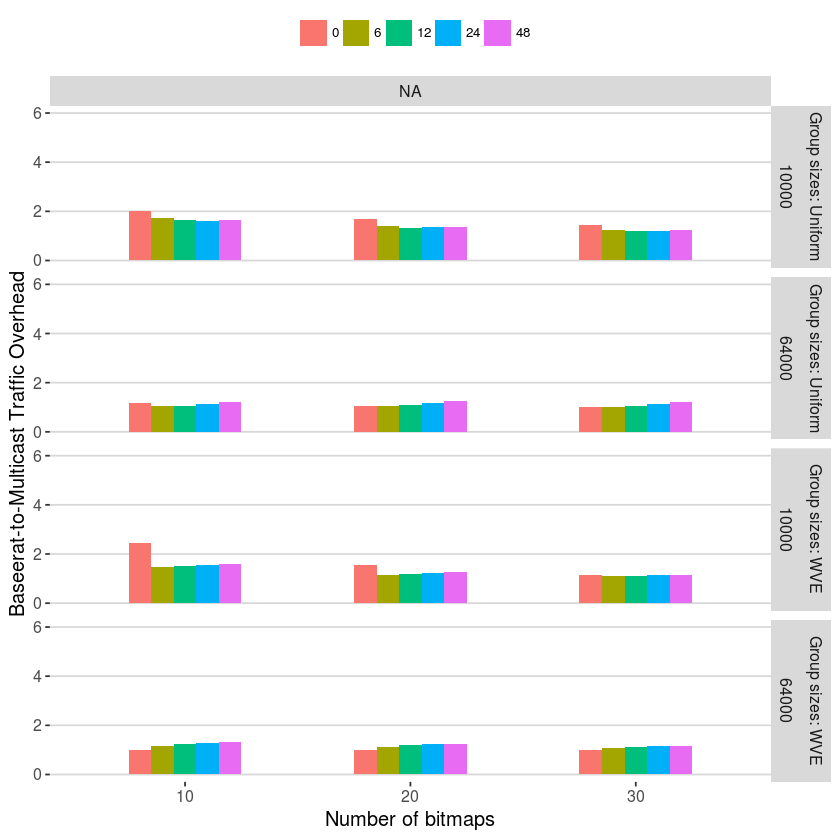

In [295]:
plt <- ggplot(trafficPerGroupPerTenant, 
       aes(y=baseeratTraffic/multicastTraffic, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 6)) +
    xlab("Number of bitmaps") +
    ylab("Baseerat-to-Multicast Traffic Overhead") +
    plotTheme
ggsave(plt, file="baseerat_traffic_overhead_per_group_per_tenant.pdf", height=5, width=7)

In [251]:
plt <- ggplot(trafficPerGroupPerTenant, 
       aes(y=overlayTraffic/multicastTraffic, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 6)) +
    xlab("Number of bitmaps") +
    ylab("Overlay-to-Multicast Traffic Overhead") +
    plotTheme
ggsave(plt, file="overlay_traffic_overhead_per_group_per_tenant.pdf", height=5, width=7)

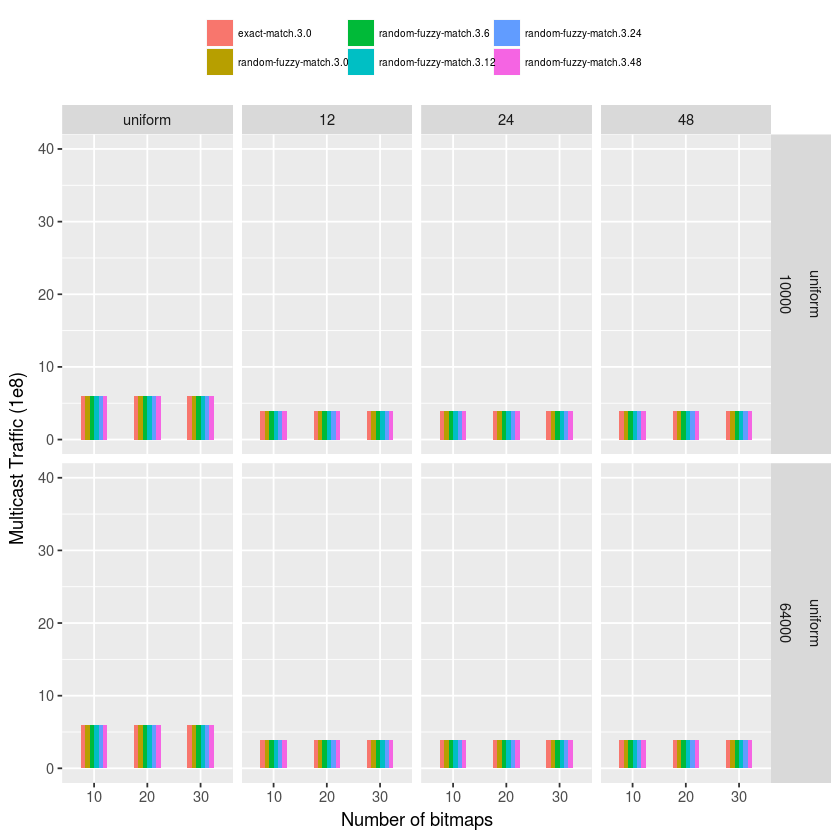

In [24]:
ggplot(trafficPerGroupPerTenant[groupSizeDist == "uniform"], 
       aes(y=multicastTraffic/1e8, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 40)) +
    xlab("Number of bitmaps") +
    ylab("Multicast Traffic (1e8)") +
    plotTheme

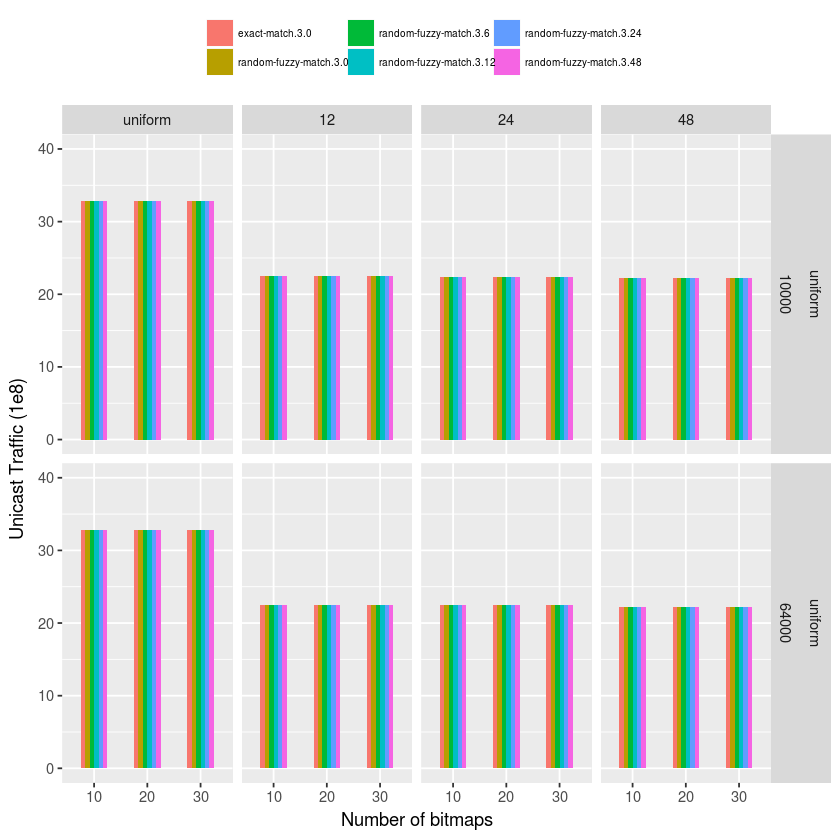

In [25]:
ggplot(trafficPerGroupPerTenant[groupSizeDist == "uniform"], 
       aes(y=unicastTraffic/1e8, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 40)) +
    xlab("Number of bitmaps") +
    ylab("Unicast Traffic (1e8)") +
    plotTheme

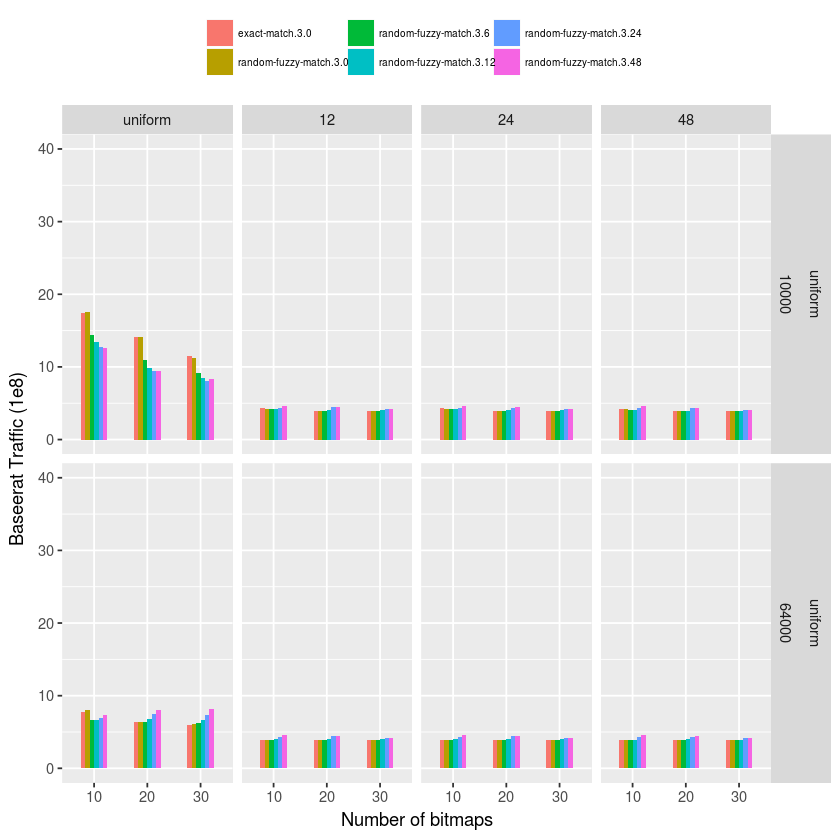

In [26]:
ggplot(trafficPerGroupPerTenant[groupSizeDist == "uniform"], 
       aes(y=baseeratTraffic/1e8, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 40)) +
    xlab("Number of bitmaps") +
    ylab("Baseerat Traffic (1e8)") +
    plotTheme

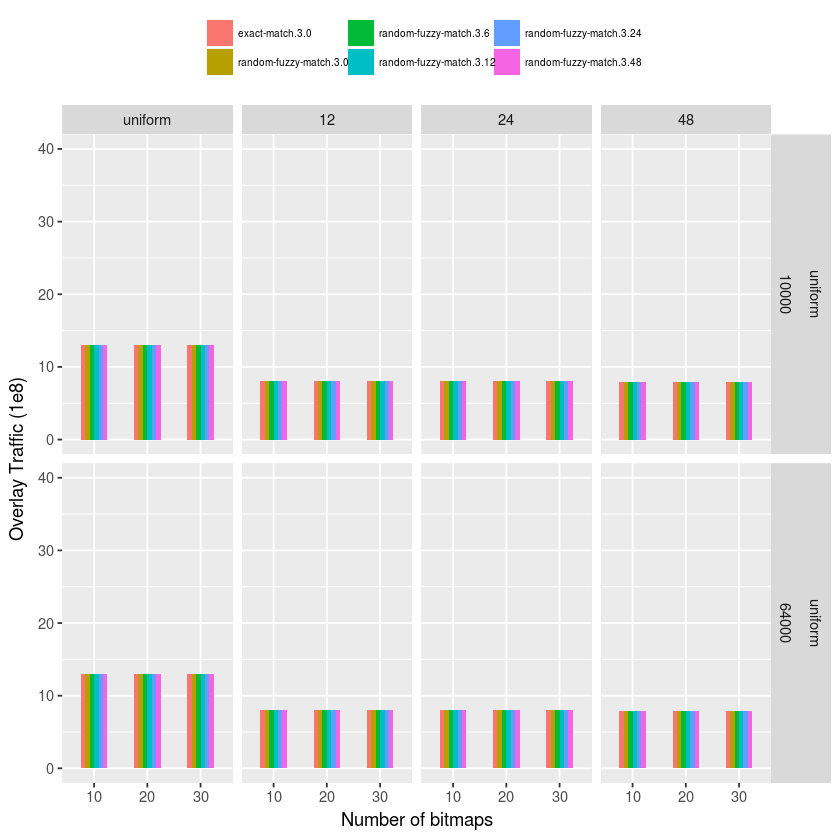

In [27]:
ggplot(trafficPerGroupPerTenant[groupSizeDist == "uniform"], 
       aes(y=overlayTraffic/1e8, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 40)) +
    xlab("Number of bitmaps") +
    ylab("Overlay Traffic (1e8)") +
    plotTheme